# Chapter 7: Ensemble learning and Random Forests

Ensemble learning is when you use a combination of independent methods and collect their
independent estimates together into a single estimate. Done often enough, this is more accurate than either estimator used separately.

Random forests are a specific ensemble method. Random forests use a collection of decision trees and use their independent estimates.

Ensemble learning also finds a way to use the dataset in creative ways, increasing the size of the data so that the  methods are as independent as possible, while still relying on the same training data.

In [146]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_iris
from sklearn.datasets import make_moons

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier


# Common functions, I will need them in the future.
def plot_dataset(X, y, axes=[-2, 2.5, -1.5, 2.0]):
    "Plot the Moons dataset with two classes: 0 and 1"
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

def show_dataset(X=X_train, y=y_train):
    plt.figure(figsize=(15, 10))
    plot_dataset(X,y)
    plt.show()

    
def plot_predictions(clf, axes=[-2, 2.5, -1.5, 2.0]):
    "Visualize what the classifier will choose on this dataset"
    x0s = np.linspace(axes[0], axes[1], 200)
    x1s = np.linspace(axes[2], axes[3], 200)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

def show_prediction(clf, X=X_train, y=y_train):
    plt.figure(figsize=(15, 10))
    plot_dataset(X, y)
    plot_predictions(clf)
    plt.show()

    
def split(X, y, test_size=0.2, random_state=42):
    # This is the first step, split into training and test data.

    # The semantics of np.c_ are tricky, and it is not a method call, but an array reference
    # instead.
    train, test = train_test_split(np.c_[X, y], test_size=0.2, random_state=42)
    
    # The attributes are the first two columns, and the class was the third column
    X_train = train[:, :2]
    y_train = train[:, 2]

    X_test = test[:, :2]
    y_test = test[:, 2]

    return X_train, y_train, X_test, y_test

In [99]:
# Create a random dataset with "moons" that you have to separate
X7, y7 = make_moons(n_samples=10000, noise=0.4)


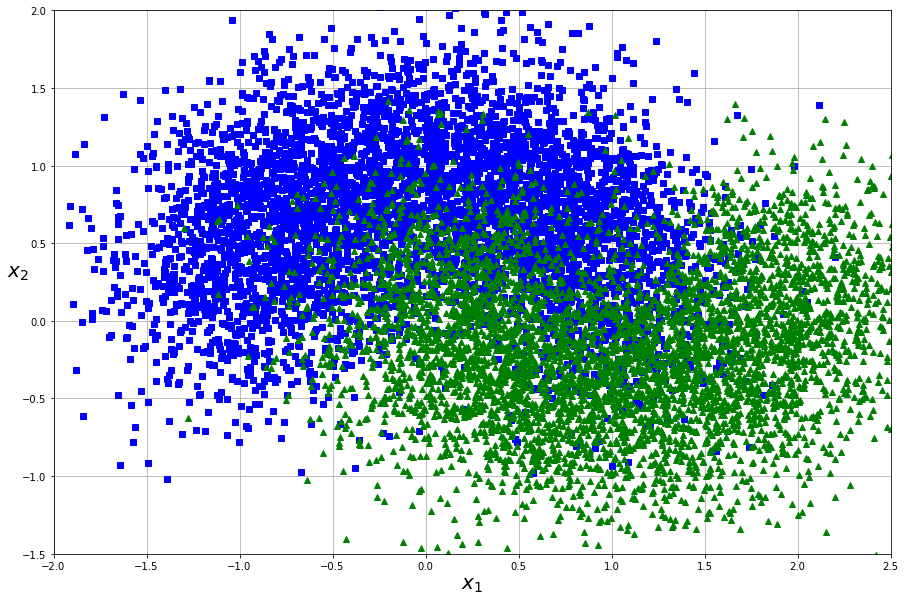

In [100]:
# Plot the data
plt.figure(figsize=(15, 10))
plot_dataset(X7, y7)
plt.show()

In [101]:
# Split the dataset using the split() method above.

X_train, y_train, X_test, y_test = split(X7, y7)

In [102]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
tree_clf = DecisionTreeClassifier(max_leaf_nodes=None, min_samples_leaf=50)
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf),
                ('cf', rnd_clf),
                ('svc', svm_clf),
                ('tree', tree_clf)],
    voting='hard')

for clf in log_clf, rnd_clf, svm_clf, tree_clf, voting_clf:
    clf.fit(X_train, y_train)
    print(clf.__class__.__name__, accuracy_score(y_test, clf.predict(X_test)))    


LogisticRegression 0.8285
RandomForestClassifier 0.8455
SVC 0.8585
DecisionTreeClassifier 0.856
VotingClassifier 0.861


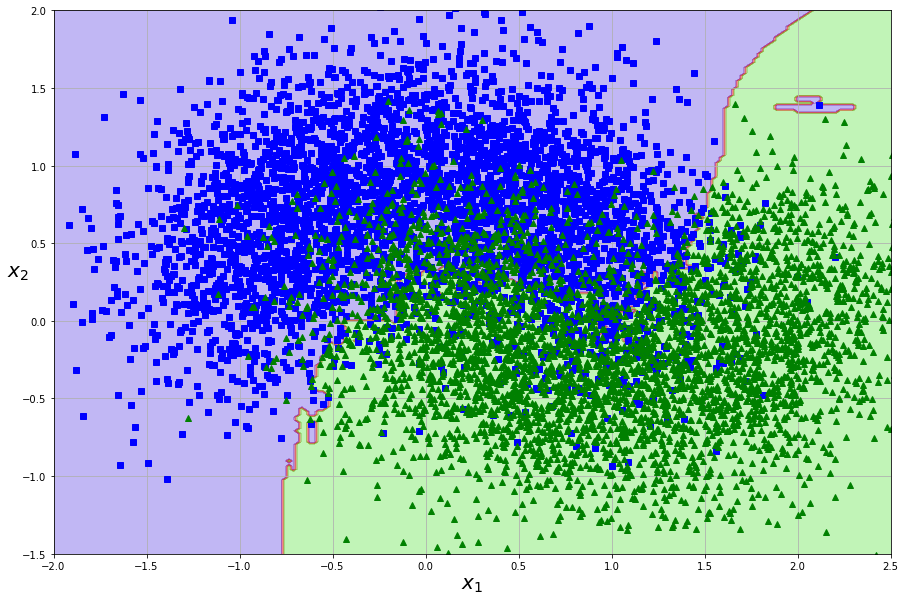

In [103]:
plt.figure(figsize=(15, 10))
plot_dataset(X_train, y_train)
plot_predictions(voting_clf)
plt.show()


That was interesting. The ensemble method was worse than SVC! Shall we use better data selection (bagging or pasting) to see if it improves anything?

In [104]:
bag_clf = BaggingClassifier(
            DecisionTreeClassifier(), n_estimators=500,
            max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)



BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


In [105]:
def print_accuracy(classifier, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    print ("Train data accuracy", accuracy_score(y_train, classifier.predict(X_train)))
    print ("Test data accuracy", accuracy_score(y_test, classifier.predict(X_test)))

In [106]:
print_accuracy(bag_clf)

Train data accuracy 0.868375
Test data accuracy 0.859


Let's try combining that with an ensemble of the prior estimators

In [107]:
# This includes the BaggingClassifier, which itself is an ensemble of decision trees.

voting2_clf = VotingClassifier(
    estimators=[('lr', log_clf),
                ('cf', rnd_clf),
                ('svc', svm_clf),
                ('tree', tree_clf),
                ('bag', bag_clf)],
    voting='hard')

voting2_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('cf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

In [108]:
print_accuracy(voting2_clf)

Train data accuracy 0.874625
Test data accuracy 0.8595


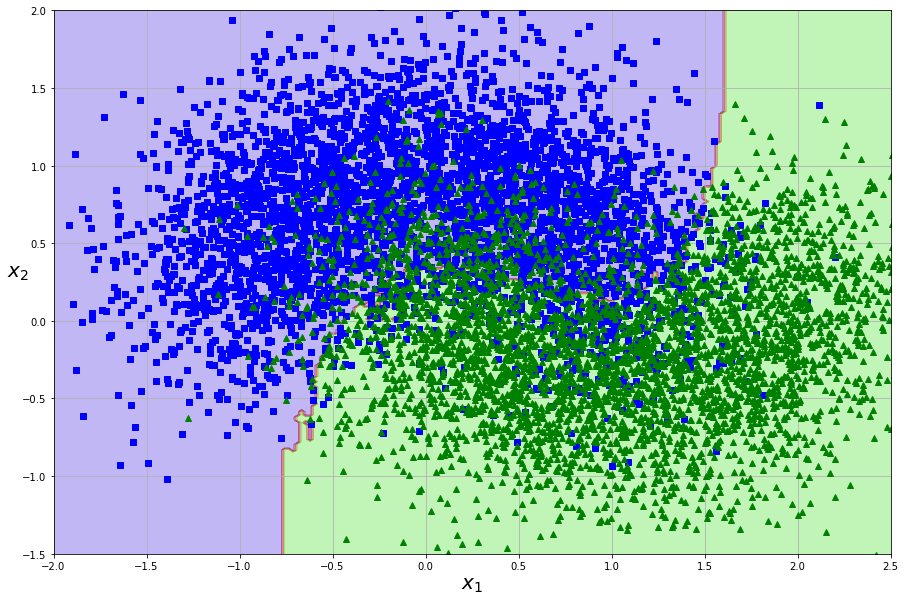

In [109]:
plt.figure(figsize=(15, 10))
plot_dataset(X_train, y_train)
plot_predictions(voting2_clf)
plt.show()


# Pasting

Pasting is drawing from the sample without replacement. Let's try that too.

In [110]:
paste_clf = BaggingClassifier(
            DecisionTreeClassifier(), n_estimators=500,
            max_samples=100, bootstrap=False, n_jobs=-1)
paste_clf.fit(X_train, y_train)


BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


In [111]:
print_accuracy(paste_clf)

Train data accuracy 0.86775
Test data accuracy 0.8595


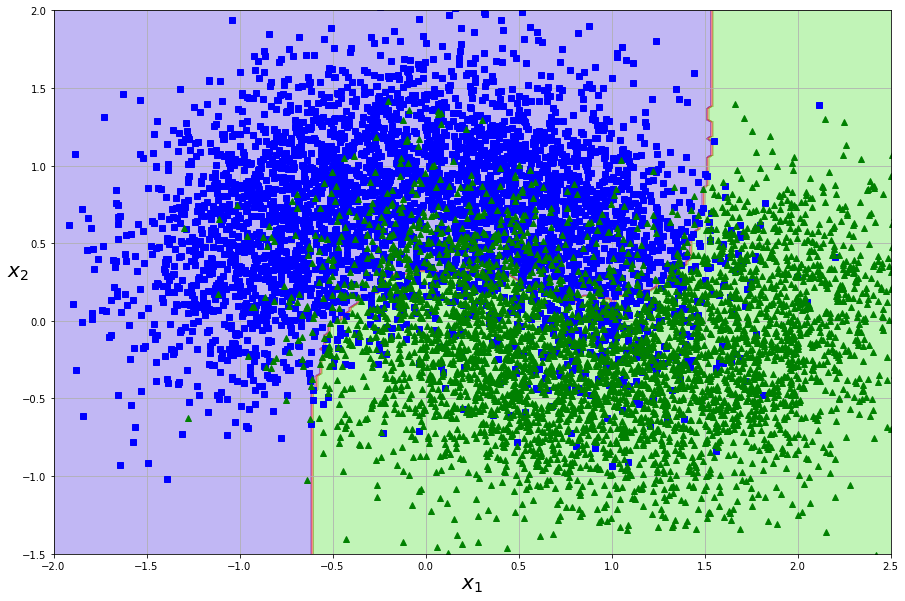

In [112]:
plt.figure(figsize=(15, 10))
plot_dataset(X_train, y_train)
plot_predictions(paste_clf)
plt.show()

So roughly the same as bagging. No big difference on this messy dataset.

In [113]:
print ("Hello Dev")

Hello Dev


In [114]:
X_clean, y_clean = make_moons(n_samples=10000, noise=0.15)

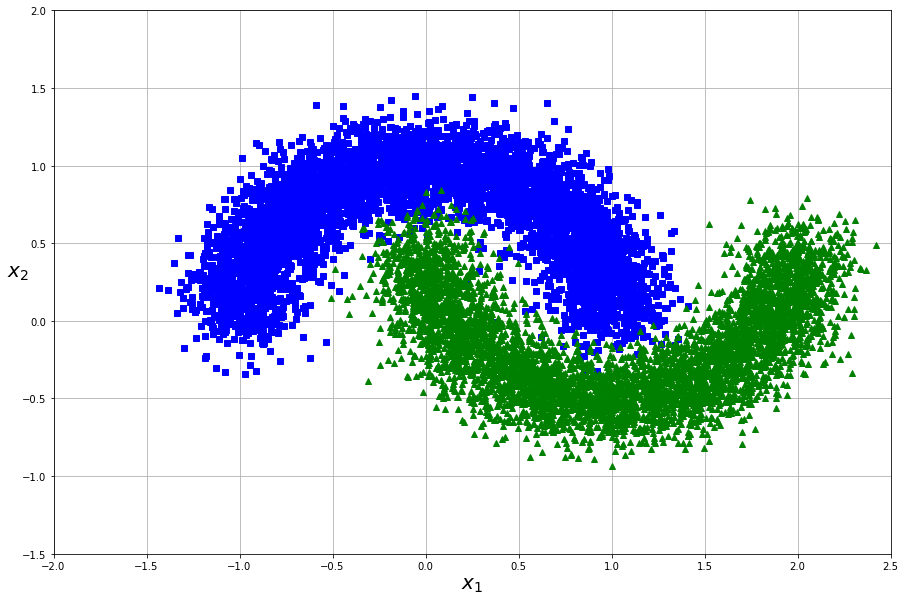

In [115]:
plt.figure(figsize=(15, 10))
plot_dataset(X_clean, y_clean)
plt.show()

In [116]:
X_clean[:5, :]

array([[-0.84843667,  0.21447667],
       [-0.54454695,  0.88922455],
       [ 2.07448874,  0.51108605],
       [ 1.23403022, -0.35894234],
       [ 0.64195744,  0.72277952]])

In [117]:
y_clean[:5]

array([0, 0, 1, 1, 0])

In [118]:
X_train, y_train, X_test, y_test = split(X_clean, y_clean)

In [119]:
clean_clf = BaggingClassifier(
            DecisionTreeClassifier(), n_estimators=500,
            max_samples=100, bootstrap=True, n_jobs=-1, oob_score=True)
clean_clf.fit(X_train, y_train)


BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


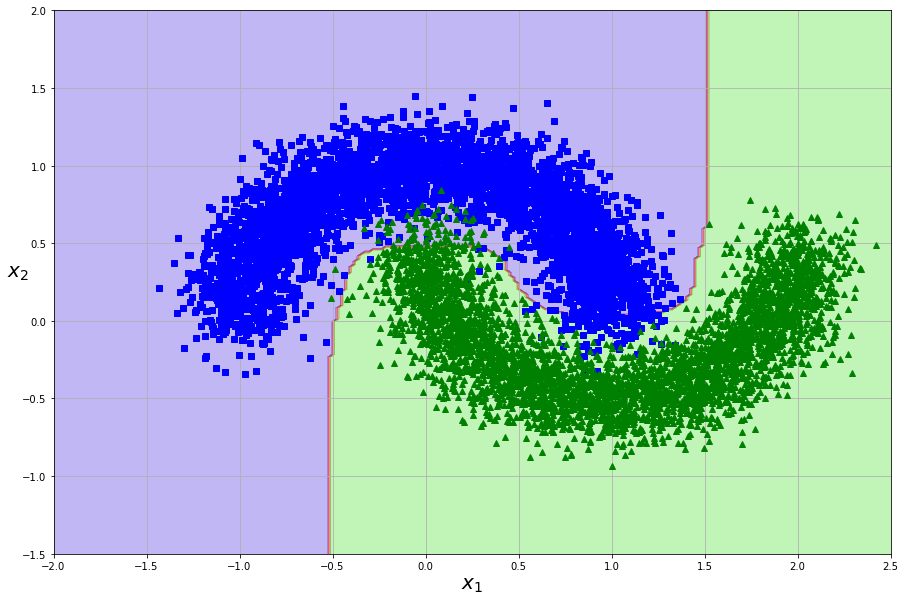

In [120]:
plt.figure(figsize=(15, 10))
plot_dataset(X_train, y_train)
plot_predictions(clean_clf)
plt.show()

In [121]:
print_accuracy(clean_clf)

Train data accuracy 0.861
Test data accuracy 0.861


In [122]:
print (clean_clf.oob_score_)

0.97575


So the Out-Of-Bag score is very close to the validation score that we got from the test data the model had never seen.

In [123]:
# Let's try with a lot more estimators
clean_clf = BaggingClassifier(
            DecisionTreeClassifier(), n_estimators=500000,
            max_samples=100, bootstrap=True, n_jobs=-1, oob_score=True)
clean_clf.fit(X_train, y_train)


KeyboardInterrupt: 

In [ ]:
# This was the accuracy with 50k estimators
print_accuracy(clean_clf)

In [ ]:
# And this is with 500k estimators
print_accuracy(clean_clf)

In [ ]:
# Delete it, it is a memory hog.
clean_clf=''

# Boosting

Hypothesis Boosting, aka Boosting is when you create a model, then find where it fails, and then increase the weights on the failures and train Model #2. Then you find errors, iterate and create Model #3. All these models are joined together in an ensemble afterwards with appropriate weights.

In [124]:
from sklearn.ensemble import AdaBoostClassifier

ada_classifier = AdaBoostClassifier(
                    DecisionTreeClassifier(max_depth=1), n_estimators=500,
                    algorithm='SAMME.R', learning_rate=0.5)
ada_classifier.fit(X_train, y_train)



AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [125]:
print_accuracy(ada_classifier)

Train data accuracy 0.8495
Test data accuracy 0.846


In [126]:
poo_poo_terrible = DecisionTreeClassifier(max_depth=2)

In [127]:
poo_poo_terrible.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

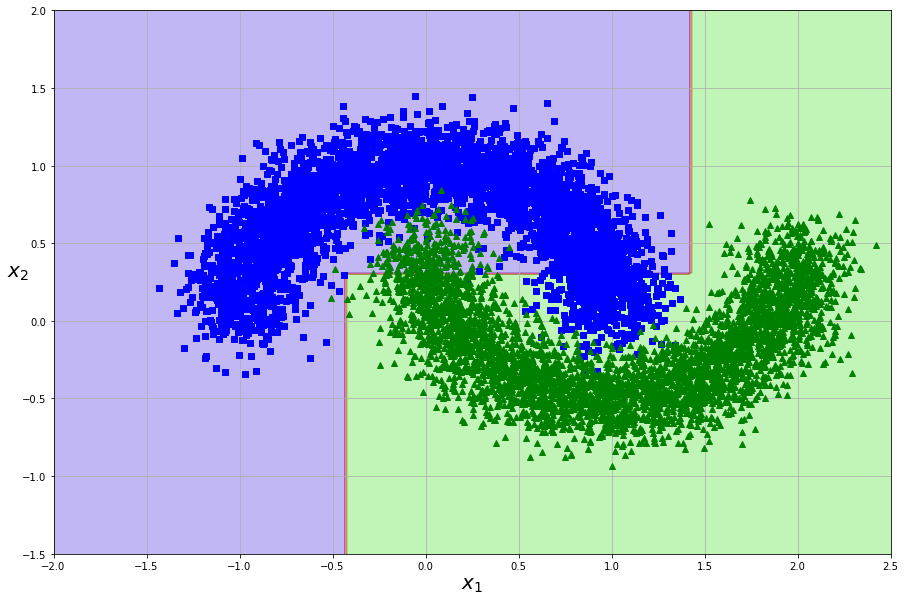

In [128]:
plt.figure(figsize=(15, 10))
plot_dataset(X_train, y_train)
plot_predictions(poo_poo_terrible)
plt.show()

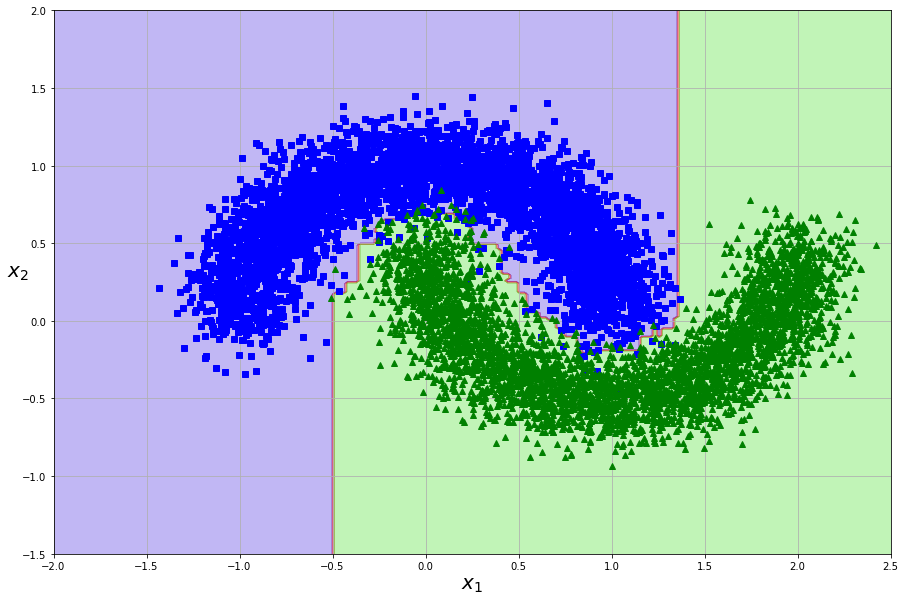

In [129]:
plt.figure(figsize=(15, 10))
plot_dataset(X_train, y_train)
plot_predictions(ada_classifier)
plt.show()

In [130]:
worse_classifier = DecisionTreeClassifier(max_depth=1)

In [131]:
worse_classifier.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

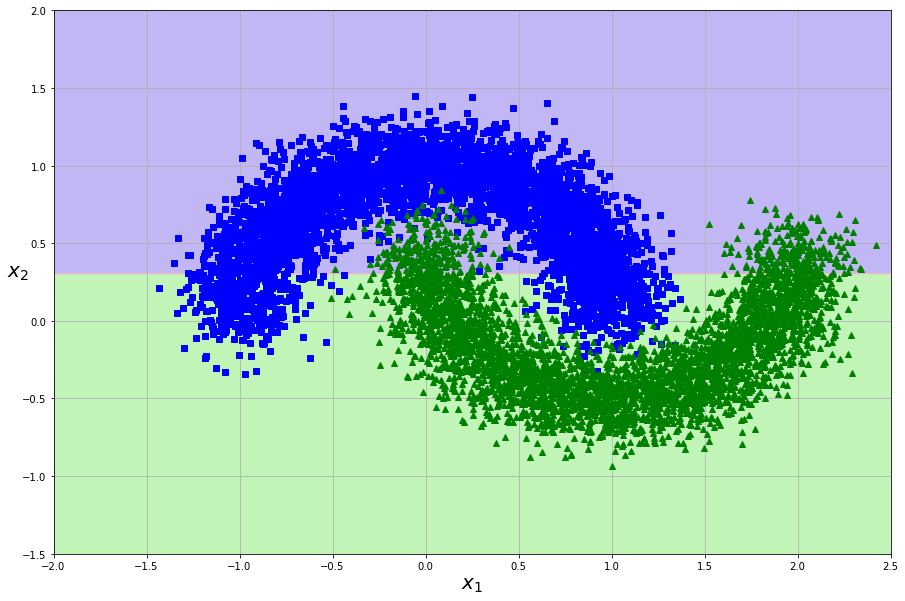

In [132]:
plt.figure(figsize=(15, 10))
plot_dataset(X_train, y_train)
plot_predictions(worse_classifier)
plt.show()

In [133]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

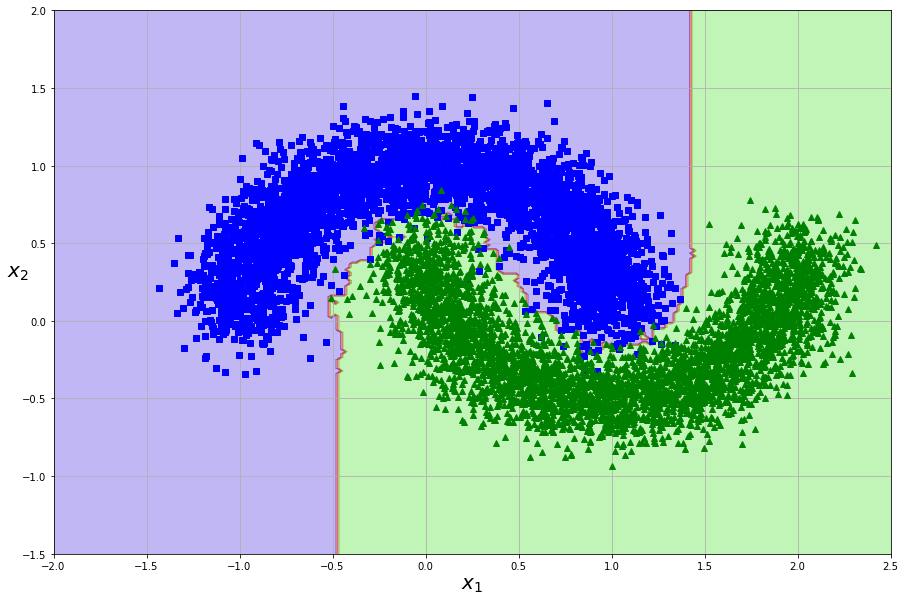

In [134]:
plt.figure(figsize=(15, 10))
plot_dataset(X_train, y_train)
plot_predictions(forest)
plt.show()

In [135]:
forest = RandomForestClassifier?

In [ ]:
forest = RandomForestClassifier

In [136]:
forest = RandomForestClassifier

In [137]:
X_separate, y_separate = make_moons(n_samples=10000, noise=0.05)

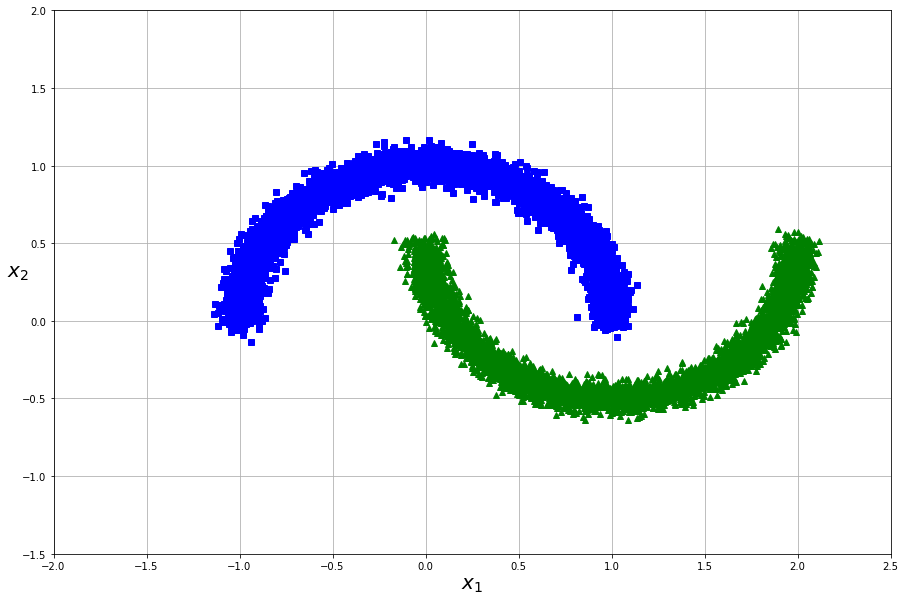

In [138]:
show_dataset(X_separate, y_separate)

In [139]:
Xs_train, ys_train, Xs_test, ys_test = split(X_separate, y_separate)

In [140]:
forest = RandomForestClassifier(min_samples_leaf=3, n_estimators=500)
forest.fit(Xs_train, ys_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

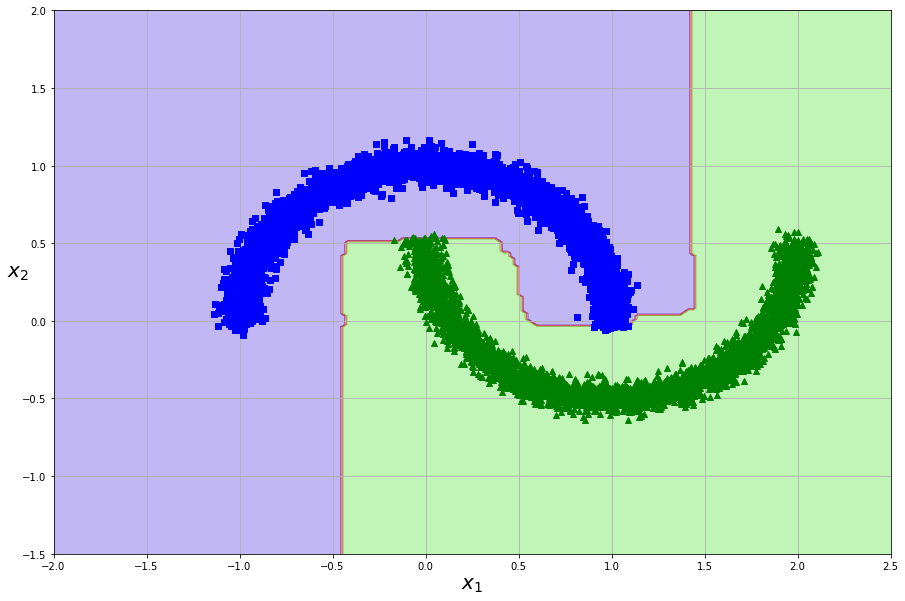

In [141]:
show_prediction(forest, Xs_train, ys_train)

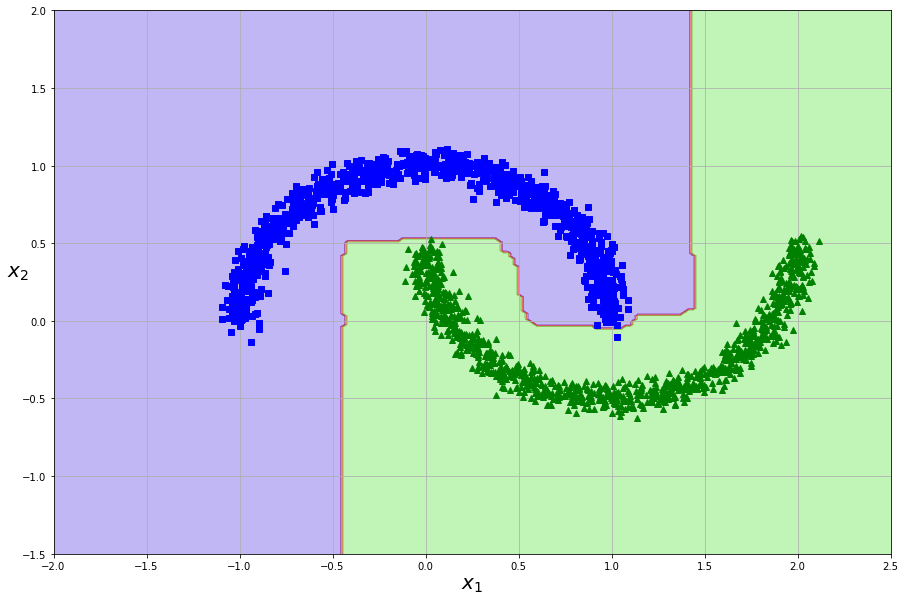

In [142]:
show_prediction(forest, Xs_test, ys_test)

In [143]:
print_accuracy(forest, Xs_train, ys_train, Xs_test, ys_test)

Train data accuracy 0.999875
Test data accuracy 0.9995


In [147]:
# Let's try a support vector classifier to see how well it does on this

p1 = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('svm_clf', LinearSVC(C=1, loss="hinge", max_iter=10000))
])

p1.fit(Xs_train, ys_train)

Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=10000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

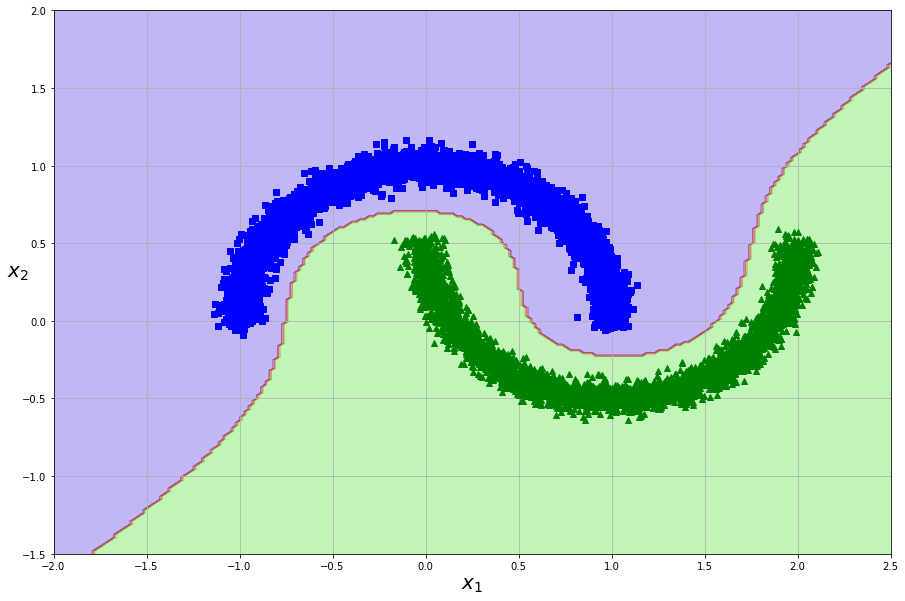

In [148]:
show_prediction(p1, Xs_train, ys_train)

In [149]:
print_accuracy(p1, Xs_train, ys_train, Xs_test, ys_test)

Train data accuracy 1.0
Test data accuracy 1.0


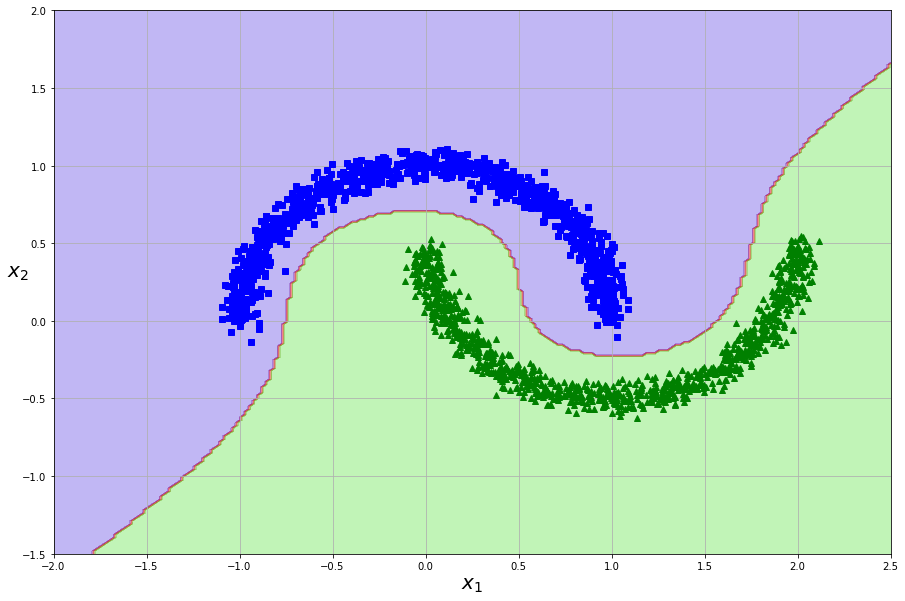

In [150]:
show_prediction(p1, Xs_test, ys_test)

This is much better because it leaves a very wide street on both sides of the support vectors, better than decision trees.

# Boosting using Gradient boosting

In this method, you train successive models on the residual errors and then add them up in an ensemble


In [153]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(max_depth=2, n_estimators=10, learning_rate=1)
gb.fit(Xs_train, ys_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=10,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
show

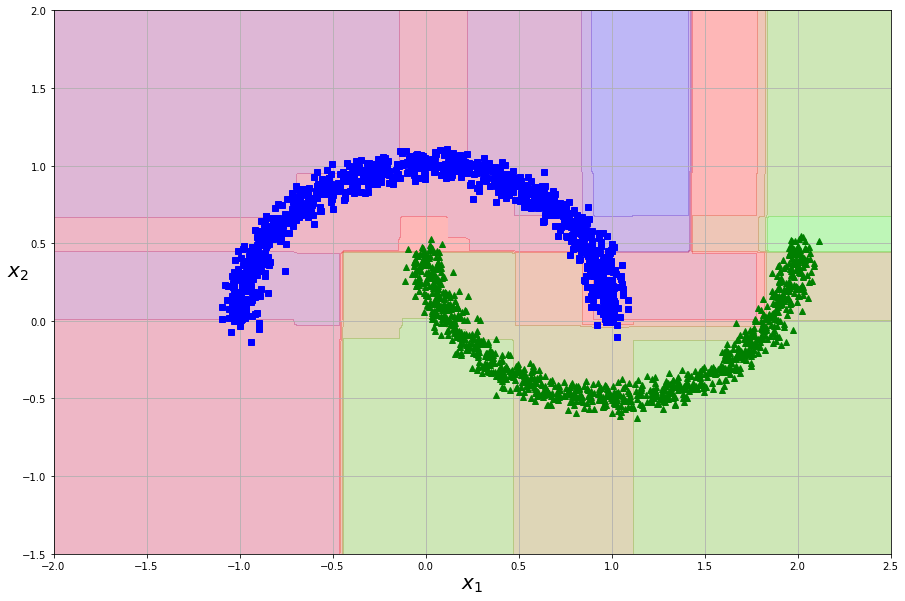

In [154]:
show_prediction(gb, Xs_test, ys_test)

# Let's combine Support vector and decision trees

Since support vectors do such a good job of matching the overall shape, let's use a support vector and fill in the losses with decision trees on the residuals.

In [147]:
# Let's try a support vector classifier to see how well it does on this

p1 = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('svm_clf', LinearSVC(C=1, loss="hinge", max_iter=10000))
])

p1.fit(X_train, y_train)


# Then, we calculate the residuals, and compute a decision tree

Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=10000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [198]:
from sklearn.calibration import CalibratedClassifierCV

p2 = CalibratedClassifierCV(
    base_estimator =  Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ('scaler', StandardScaler()),
        ('svm_clf', LinearSVC(C=1, loss="hinge", max_iter=10000))
    ]), cv=5)

p2.fit(X_train, y_train)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


CalibratedClassifierCV(base_estimator=Pipeline(memory=None,
                                               steps=[('poly_features',
                                                       PolynomialFeatures(degree=3,
                                                                          include_bias=True,
                                                                          interaction_only=False,
                                                                          order='C')),
                                                      ('scaler',
                                                       StandardScaler(copy=True,
                                                                      with_mean=True,
                                                                      with_std=True)),
                                                      ('svm_clf',
                                                       LinearSVC(C=1,
                                                   

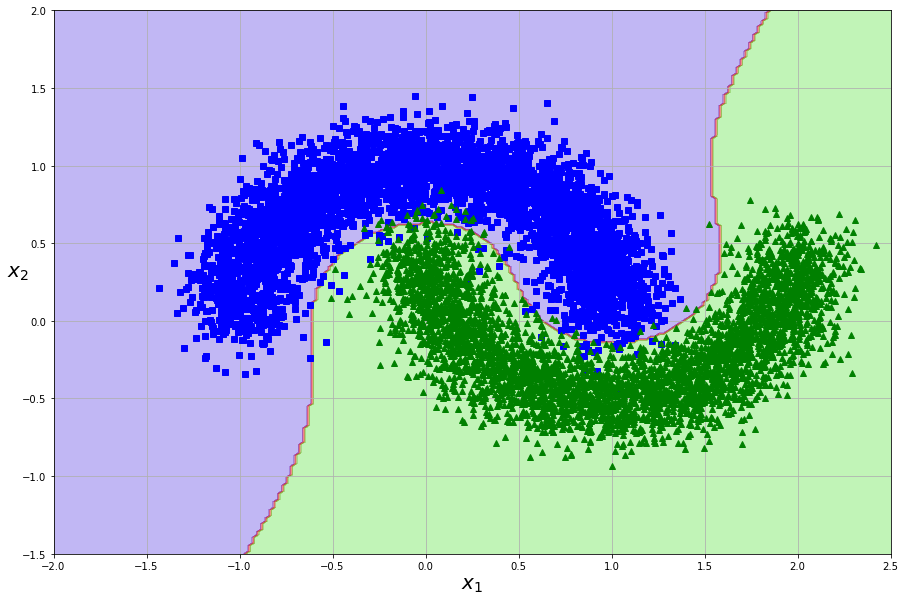

In [199]:
show_prediction(p2, X_train, y_train)

Now, let's get the residuals, and fit a decision tree to it


In [194]:
yres1_train = y_train - p1.predict(X_train)

In [195]:
treeres1 = RandomForestClassifier(n_estimators=200)
treeres1.fit(X_train, yres1_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [196]:
# And collect them together in a single estimator
class Combined():
    def __init__(self): # No arguments
        return None # Nothing to do
    def fit(self, X, y=None):
        return self # Do nothing since we aren't going to train this
                    # estimator, just predict.
    def predict(self, X):
        # Get a class probability from the individual predictors
        # If it is higher than 0.5, then 
        y_pred = p1.predict_proba(X) + treeres1.predict_proba(X) >= 0.5
        return (y_pred)
        
combined = Combined()

Dang, I don't understand enough to create an estimator that looks exactly like a DecisionTreeClasssifier and can be used directly. Got to learn this.

In [201]:
# Ah, this doesn't work because you can't fit a classifier for residuals.
# Ok, this is more complicated than I expected. I need to fit a regressor.
# Abandoning this here.

p2.predict_proba([[0, 0]])+treeres1.predict_proba([[0, 0]])

ValueError: operands could not be broadcast together with shapes (1,2) (1,3) 

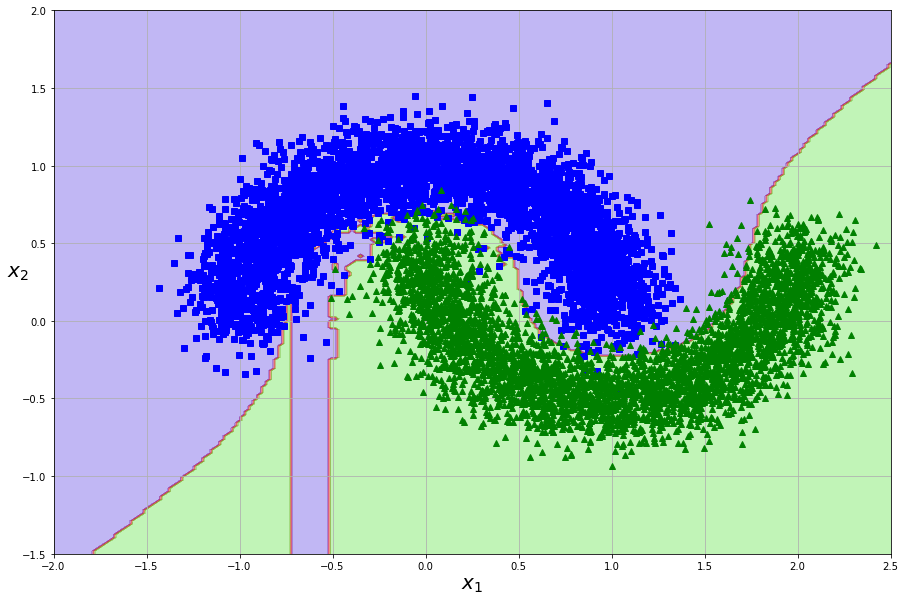

In [186]:
show_prediction(combined, X_train, y_train)

In [189]:
treeres1.predict_proba([[0,0]])

array([[0., 1., 0.]])

That did it! Or at least, it worked. It found two areas to hand-fix, and then the errors should be smaller.

The correct way to do this is to predict_proba() and then add the probabilities to
get the correct class that we should use. But since this was just me playing, I'm going to leave it here. I have to find how to enable predict_proba for the LinearSVC, which does not allow for it.

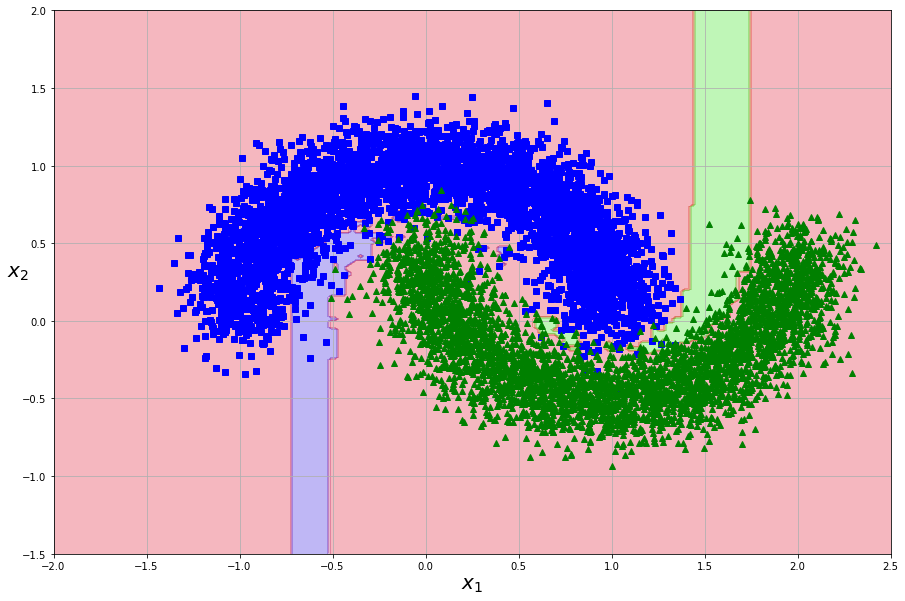

In [187]:
show_prediction(treeres1, X_train, y_train)